# Convolutional auto encoder

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import tensorflow.examples.tutorials.mnist.input_data as input_data
%matplotlib inline

In [2]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimgs = mnist.train.images
print(trainimgs.shape)
trainlabels = mnist.train.labels
testimgs = mnist.test.images
testlabels = mnist.test.labels
n_train = trainimgs.shape[0]
n_test = testimgs.shape[0]
dim = trainimgs.shape[1]

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
(55000, 784)


# Define Networks

In [3]:
n1 = 16
n2 = 32
n3 = 64
ksize = 6
stddev = 0.1
w = {
    'c1': tf.Variable(tf.random_normal([ksize, ksize, 1, n1], stddev=stddev)),
    'c2': tf.Variable(tf.random_normal([ksize, ksize, n1, n2], stddev=stddev)),
    'c3': tf.Variable(tf.random_normal([ksize, ksize, n2, n3], stddev=stddev)),
    'cd3': tf.Variable(tf.random_normal([ksize, ksize, n2, n3], stddev=stddev)), #deconv weights
    'cd2': tf.Variable(tf.random_normal([ksize, ksize, n1, n2], stddev=stddev)),
    'cd1': tf.Variable(tf.random_normal([ksize, ksize, 1, n1], stddev=stddev))
}
b = {
    'b1': tf.Variable(tf.random_normal([n1], stddev=stddev)),
    'b2': tf.Variable(tf.random_normal([n2], stddev=stddev)),
    'b3': tf.Variable(tf.random_normal([n3], stddev=stddev)),
    'bd3': tf.Variable(tf.random_normal([n2], stddev=stddev)),
    'bd2': tf.Variable(tf.random_normal([n1], stddev=stddev)),
    'bd1': tf.Variable(tf.random_normal([1], stddev=stddev)),
}
print(trainimgs.shape[1])

784


In [4]:
def cae(_x, _w, _b, _keepprob):
    _input = tf.reshape(_x,shape=[-1,28,28,1])
    #Encoder
    _ce1 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_input, _w['c1'], strides=[1,2,2,1], padding="SAME"),_b['b1']))
    _ce1 = tf.nn.dropout(_ce1, _keepprob)
    _ce2 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_ce1, _w['c2'], strides=[1,2,2,1], padding="SAME"), _b['b2']))
    _ce2 = tf.nn.dropout(_ce2, _keepprob)
    _ce3 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_ce2, _w['c3'], strides=[1,2,2,1], padding="SAME"), _b['b3']))
    _ce3 = tf.nn.dropout(_ce3, _keepprob)
    
    #Decoder
    _cd3 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(_ce3, _w['cd3'], 
                                                       tf.stack([tf.shape(_x)[0],7,7,n2]), strides=[1,2,2,1],
                                                      padding = 'SAME'), _b['bd3']))
    #tf.pack -> tf.stack / tf.unpack -> tf.unstack 로 바뀜
    _cd3 = tf.nn.dropout(_cd3, _keepprob)
    _cd2 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(_cd3, _w['cd2'], 
                                                       tf.stack([tf.shape(_x)[0],14,14,n1]), strides=[1,2,2,1],
                                                      padding = 'SAME'), _b['bd2']))
    _cd2 = tf.nn.dropout(_cd2, _keepprob)
    _cd1 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(_cd2, _w['cd1'], 
                                                       tf.stack([tf.shape(_x)[0],28,28,1]), strides=[1,2,2,1],
                                                      padding = 'SAME'), _b['bd1']))
    _out = tf.nn.dropout(_cd1, _keepprob)
    return _out
print('Build Network')

Build Network


# Define Functions

In [ ]:
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 784])
keepprob = tf.placeholder(tf.float32)
pred = cae(x, w, b, keepprob)
cost = tf.reduce_sum(tf.square(pred - tf.reshape(y, [-1,28,28,1])))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
print("function ready")

function ready


1391.08


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


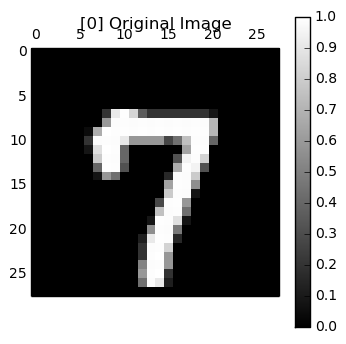

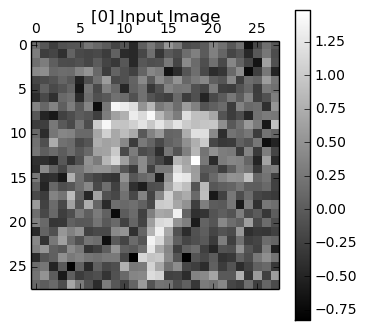

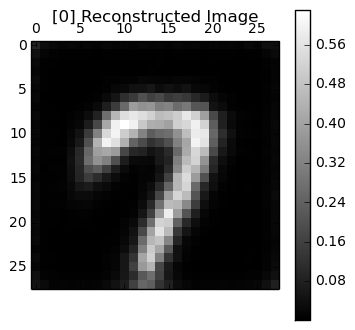

In [ ]:
epochs = 20
batch_size = 50
for epoch in range(epochs):
    for batch_i in range(int(mnist.train.num_examples/batch_size)):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        xs_noise = batch_xs + 0.3*np.random.randn(batch_xs.shape[0], 784)
        sess.run(optm, feed_dict={x : xs_noise, y : batch_xs, keepprob : 0.7})
    print(sess.run(cost, feed_dict={x : xs_noise, y : batch_xs, keepprob : 1}))
    
    if(epoch%1) == 0:
        randidx  = np.random.randint(testimgs.shape[0], size=1)
        testvec  = testimgs[randidx, :]
        noisyvec = testvec + 0.3*np.random.randn(1, 784)
        outvec   = sess.run(pred, feed_dict={x: noisyvec, keepprob: 1.})
        outimg   = np.reshape(outvec, (28, 28))

        # PLOT 
        plt.matshow(np.reshape(testvec, (28, 28)), cmap=plt.get_cmap('gray'))
        plt.title("[" + str(epoch) + "] Original Image")
        plt.colorbar()
        plt.matshow(np.reshape(noisyvec, (28, 28)), cmap=plt.get_cmap('gray'))
        plt.title("[" + str(epoch) + "] Input Image")
        plt.colorbar()
        plt.matshow(outimg, cmap=plt.get_cmap('gray'))
        plt.title("[" + str(epoch) + "] Reconstructed Image")
        plt.colorbar()
        plt.show()
print("training done")  